In [ ]:
import nltk
import numpy as np
import math
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score,
    recall_score, fbeta_score, classification_report
)

In [ ]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
start_token = '$'
end_token = '$'

tagged_sentences = nltk.corpus.brown.tagged_sents(tagset='universal')

In [ ]:
# Initialize constants for start and end tokens
START_PAIR = (start_token, start_token)
END_PAIR = (end_token, end_token)

processed_sentences = []

# Process each sentence: add start and end tokens, and convert words to lowercase
for sentence in tagged_sentences:
    temp_sentence = [START_PAIR]  # Add start token
    temp_sentence += [(word.lower(), tag) for word, tag in sentence]  # Lowercase words and add tags
    temp_sentence.append(END_PAIR)  # Add end token
    processed_sentences.append(temp_sentence)  # Add processed sentence to the list

# Update tagged_sentences with the processed version
tagged_sentences = processed_sentences

In [ ]:
def train_model(sentences):
    """
    Train a model using the given sentences to obtain POS tag counts,
    word-POS tag counts, and tag transition counts.
    """
    all_word_tag_pairs = []

    # Collect all (word, tag) pairs from the sentences
    for sentence in sentences:
        all_word_tag_pairs.extend(sentence)

    # Count occurrences of each POS tag
    pos_tag_counts = Counter(tag for _, tag in all_word_tag_pairs)

    # Count occurrences of each word with its corresponding POS tags
    word_pos_tag_counts = defaultdict(Counter)
    for word, pos_tag in all_word_tag_pairs:
        word_pos_tag_counts[word][pos_tag] += 1

    # Count transitions between consecutive POS tags
    tag_transition_counts = defaultdict(Counter)
    for sentence in sentences:
        for i in range(len(sentence) - 1):
            current_tag = sentence[i][1]
            next_tag = sentence[i + 1][1]
            tag_transition_counts[current_tag][next_tag] += 1

    return pos_tag_counts, word_pos_tag_counts, tag_transition_counts

In [ ]:
def compute_transition_probability(tag1, tag2, pos_tag_counts, tag_transition_counts):
    """
    Calculate the probability of transitioning from tag1 to tag2.
    Applies smoothing to handle zero probabilities.
    """
    tag1_to_tag2_count = tag_transition_counts[tag1][tag2]
    tag1_total_count = pos_tag_counts[tag1]
    probability = tag1_to_tag2_count / tag1_total_count

    # Apply smoothing to avoid zero probability
    if probability == 0:
        probability = 10**-9

    return probability


In [ ]:
def compute_lexical_probability(word, tag, pos_tag_counts, word_pos_tag_counts):
    """
    Calculate the probability of a word given a POS tag.
    Uses Laplace smoothing to handle zero probabilities.
    """
    word_given_tag_count = word_pos_tag_counts[word][tag]
    tag_total_count = pos_tag_counts[tag]

    # Apply Laplace smoothing to avoid zero probability
    probability = (word_given_tag_count + 1) / (tag_total_count + len(word_pos_tag_counts))

    return probability

In [ ]:
def viterbi_algorithm(untagged_sentence, pos_tag_counts, word_pos_tag_counts, tag_transition_counts):
    """
    Implement the Viterbi algorithm to find the most likely sequence of POS tags for a given sentence.
    """
    n = len(untagged_sentence)
    prev_probs = defaultdict(Counter)
    curr_probs = defaultdict(Counter)
    parent_tags = defaultdict(Counter)

    # Initialize probabilities for the start token
    for tag in pos_tag_counts:
        prev_probs[tag] = 0.0
    prev_probs[start_token] = 0.0
    parent_tags[0][start_token] = 0

    # Iterate through each word in the sentence
    for i in range(1, n - 1):
        word = untagged_sentence[i]
        for curr_tag in pos_tag_counts:
            curr_probs[curr_tag] = 1.0
            for prev_tag in pos_tag_counts:
                transition_prob = math.log(compute_transition_probability(prev_tag, curr_tag, pos_tag_counts, tag_transition_counts))
                emission_prob = math.log(compute_lexical_probability(word, curr_tag, pos_tag_counts, word_pos_tag_counts))
                score = prev_probs[prev_tag] + emission_prob + transition_prob

                # Update the maximum probability and set the parent tag
                if curr_probs[curr_tag] == 1.0 or score > curr_probs[curr_tag]:
                    curr_probs[curr_tag] = score
                    parent_tags[i][curr_tag] = prev_tag

        # Update previous probabilities for the next iteration
        for tag in pos_tag_counts:
            prev_probs[tag] = curr_probs[tag]

    # Backtrack to determine the most likely sequence of tags
    final_tags = [start_token for _ in range(n)]
    for tag in pos_tag_counts:
        if curr_probs[tag] > curr_probs[final_tags[n - 2]]:
            final_tags[n - 2] = tag
    for i in range(n - 3, 0, -1):
        final_tags[i] = parent_tags[i + 1][final_tags[i + 1]]

    final_tags[0] = start_token
    return final_tags


In [ ]:
# Initialize counters for the final fold
Last_POS_tag_counts, Last_word_pos_tags, Last_Tag_transition_count = defaultdict(Counter), defaultdict(Counter), defaultdict(Counter)

# Set up K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
tagged_sentences = np.array(tagged_sentences, dtype='object')

# Lists to store predictions and true labels
y_pred_list = []
y_true_list = []

# Perform cross-validation
for fold, (train_indices, test_indices) in enumerate(kfold.split(tagged_sentences)):
    train_sentences = tagged_sentences[train_indices]
    test_sentences = tagged_sentences[test_indices]

    # Train model
    POS_tag_counts, word_pos_tag_counts, Tag_transition_count = train_model(train_sentences)

    # Store model parameters from the fourth fold
    if fold == 3:
        Last_POS_tag_counts = POS_tag_counts
        Last_word_pos_tags = word_pos_tag_counts
        Last_Tag_transition_count = Tag_transition_count

    y_pred = []
    y_true = []

    # Evaluate model on test sentences
    for sentence in test_sentences:
        untagged_sentence = [word for word, tag in sentence]
        prediction = viterbi_algorithm(untagged_sentence, POS_tag_counts, word_pos_tag_counts, Tag_transition_count)

        for i in range(1, len(prediction) - 1):
            y_pred.append(prediction[i])
            y_true.append(sentence[i][1])

    y_pred_list.append(np.array(y_pred))
    y_true_list.append(np.array(y_true))

    # Print accuracy for current fold
    accuracy = accuracy_score(y_true_list[-1], y_pred_list[-1], normalize=True)
    print(f'Accuracy for Fold {fold + 1}: {accuracy}')

Accuracy for Fold 1: 0.9374911263988023
Accuracy for Fold 2: 0.9374420340182127
Accuracy for Fold 3: 0.9370044526662221
Accuracy for Fold 4: 0.9377399654707403
Accuracy for Fold 5: 0.9371689552908876


In [ ]:
# Calculate and print performance metrics
f0_5_score = 0
f1score = 0
f2score = 0
precision = 0
recall = 0

for i in range(5):
    f0_5_score += fbeta_score(y_true_list[i], y_pred_list[i], beta=0.5, average='weighted', zero_division=0)
    f1score += fbeta_score(y_true_list[i], y_pred_list[i], beta=1, average='weighted', zero_division=0)
    f2score += fbeta_score(y_true_list[i], y_pred_list[i], beta=2, average='weighted', zero_division=0)
    precision += precision_score(y_true_list[i], y_pred_list[i], average='weighted', zero_division=0)
    recall += recall_score(y_true_list[i], y_pred_list[i], average='weighted', zero_division=0)

# Average metrics across all folds
f0_5_score /= 5.0
f1score /= 5.0
f2score /= 5.0
precision /= 5.0
recall /= 5.0

# Print the averaged performance metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F0.5 Score: {f0_5_score}')
print(f'F1 Score: {f1score}')
print(f'F2 Score: {f2score}')

Precision: 0.941637077836828
Recall: 0.937369306768973
F0.5 Score: 0.9403381629447862
F1 Score: 0.9388109332923454
F2 Score: 0.9377789498176281


In [ ]:
def classification_report_function(y_true_list,y_pred_list):
    tagset = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
    report = 0
    support = 0
    check = 0
    for i in range(5):
        cr = classification_report(y_true_list[i],y_pred_list[i],labels=tagset,zero_division=0)
        cr = cr.replace('macro avg', 'macro')
        cr = cr.replace('micro avg', 'micro')
        cr = cr.replace('weighted avg', 'weighted')
        cr = cr.replace('\n\n', '\n')
        lines = cr.split('\n')
        classes , mat , sup = [], [], []
        for line in lines[1:]:
            a = line.strip().split()
            if len(a) < 2:
                continue
            temp = [float(x) for x in a[1: len(a) - 1]]
            sup.append(int(a[-1]))
            classes.append(a[0])
            mat.append(temp)
        mat = np.array(mat)
        sup = np.array(sup)
        if(i==0):
            report = mat
            support = sup
        else:
            report+=mat
            support+=sup
    report = report/5.0
    support = support/5.0
    xticklabels = ['Precision', 'Recall', 'F1-Score']
    yticklabels = ['{0}[{1}]'.format(classes[i], sup_i) for i, sup_i in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(18,10))
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    plt.imshow(report, aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels)
    plt.yticks(np.arange(len(classes)), yticklabels)
    for i in range(report.shape[0]):
        for j in range(report.shape[1]):
            plt.text(j, i, format(report[i, j], '.2f'), horizontalalignment="center", verticalalignment="center" ,fontsize=10)
    plt.savefig('classification_report.png')


In [ ]:
def confusion_matrix_function(y_true_list,y_pred_list):
    list_of_tags = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
    count = 0
    mat = 0
    for y_true,y_pred in zip(y_true_list,y_pred_list):
        cm = confusion_matrix(y_true,y_pred,labels=list_of_tags)
        count += 1
        if(count==1):
            mat = cm
        else:
            mat += cm

    mat = mat.astype('float')
    mat = mat/count
    mat_confusion_matrix = mat/np.sum(mat, axis=1, keepdims=True) #With Normalization
    #mat_confusion_matrix = mat  #Without Normalization
    plt.clf()
    fig, ax = plt.subplots(figsize=(12,10))
    tick_marks = np.arange(len(list_of_tags))
    plt.xticks(tick_marks, list_of_tags)
    plt.yticks(tick_marks, list_of_tags)
    for i in range(mat_confusion_matrix.shape[0]):
            for j in range(mat_confusion_matrix.shape[1]):
                plt.text(j, i, format(mat_confusion_matrix[i, j], '0.2f'), horizontalalignment="center")
    plt.imshow(mat_confusion_matrix,interpolation='nearest',cmap=plt.cm.cool)
    plt.colorbar()
    plt.savefig('confusion_matrix.png')

<Figure size 640x480 with 0 Axes>

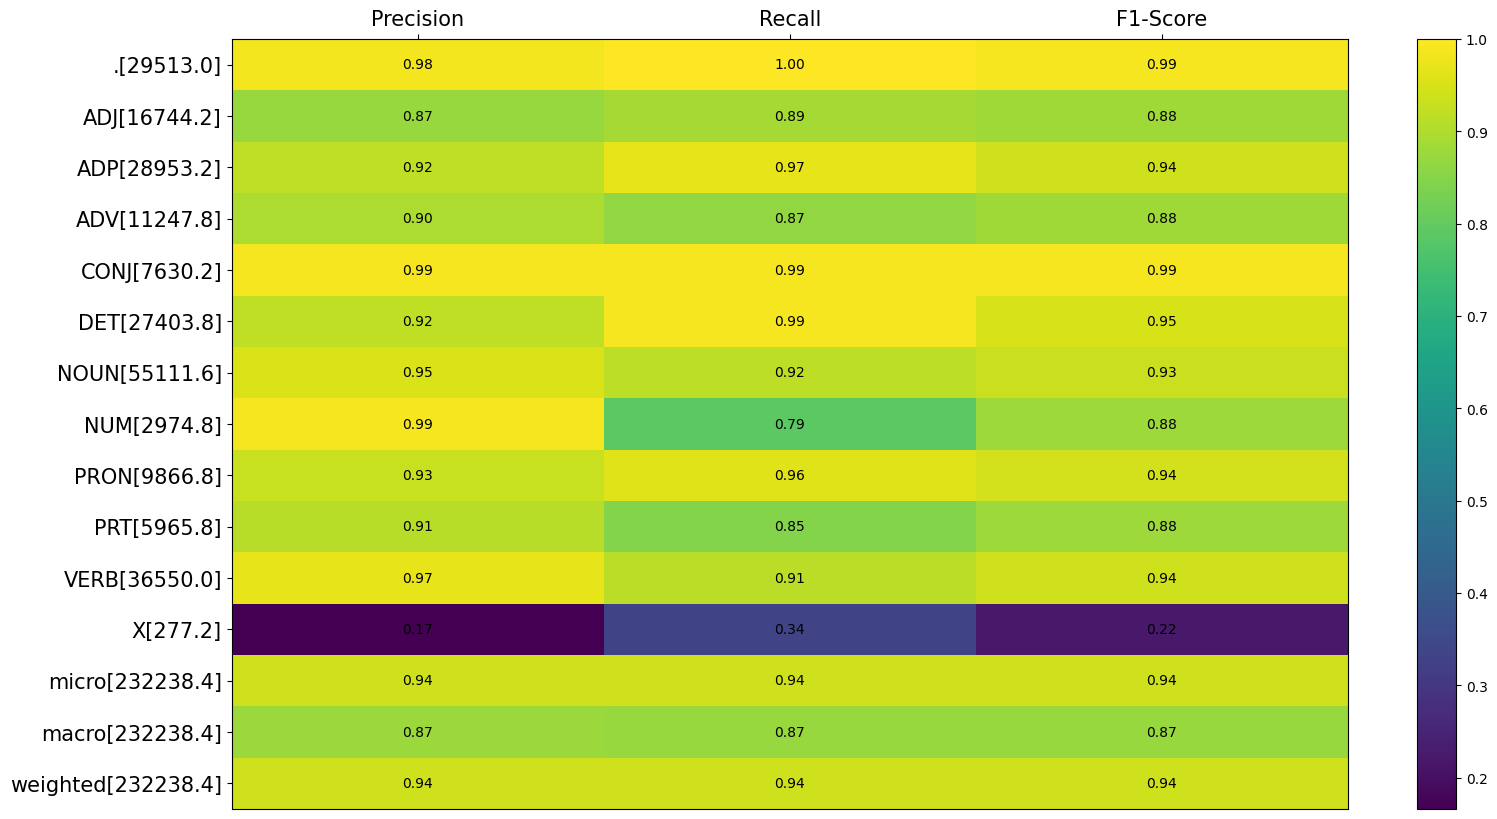

In [ ]:
classification_report_function(y_true_list,y_pred_list)

<Figure size 640x480 with 0 Axes>

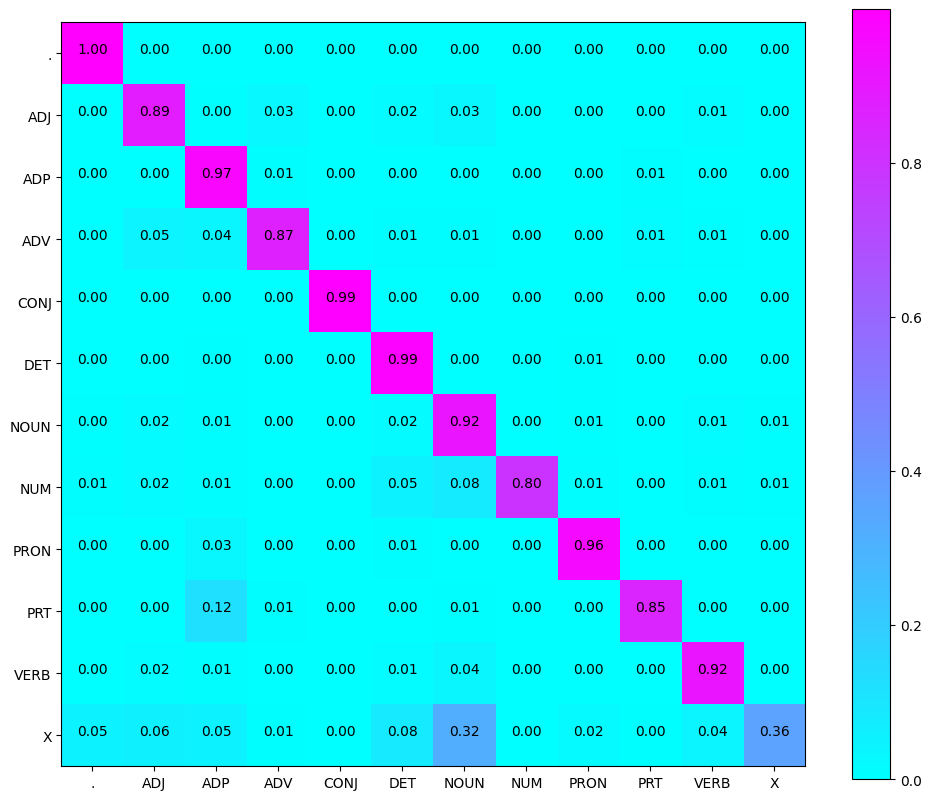

In [ ]:
confusion_matrix_function(y_true_list,y_pred_list)

In [ ]:
def sentence_checking(untagged_sentence,Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count):
    untagged_sentence = untagged_sentence.lower()
    sentence_list = untagged_sentence.split()
    sentence_list = ['$'] + sentence_list + ['$']
    print(viterbi_algorithm(sentence_list,Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count))

In [ ]:
for_checking = 'I am fooling myself'
sentence_checking(for_checking,Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count)

['$', 'PRON', 'VERB', 'VERB', 'PRON', '$']


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create a text input widget with a customized layout
text_input = widgets.Text(
    description='Enter:',
    placeholder='Type something...',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px', margin='10px 0px')
)

# Create a button to submit input
submit_button = widgets.Button(
    description='Submit',
    button_style='success',  # 'success', 'info', 'warning', 'danger'
    layout=widgets.Layout(width='100px', margin='10px 0px')
)

# Output widget to display the user's input
output = widgets.Output()

# Variable to store user input
user_input = ""

# Function to handle button click event
def handle_submit(sender):
    global user_input
    with output:
        output.clear_output()  # Clear previous output
        user_input = text_input.value
        print(f'You entered: {user_input}')

# Display text input, button, and output
display(text_input, submit_button, output)

# Bind the button to the function
submit_button.on_click(handle_submit)


Text(value='', description='Enter:', layout=Layout(margin='10px 0px', width='400px'), placeholder='Type someth…

Button(button_style='success', description='Submit', layout=Layout(margin='10px 0px', width='100px'), style=Bu…

Output()

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing

In [ ]:
import gradio as gr

def sentence_checking(untagged_sentence, Last_POS_tag_counts, Last_word_pos_tags, Last_Tag_transition_count):
    # Assuming 'sentence_checking' returns POS tags for a given sentence
    untagged_sentence = untagged_sentence.lower()
    sentence_list = untagged_sentence.split()
    sentence_list = ['^'] + sentence_list + ['$']
    pos_tags = viterbi_algorithm(sentence_list, Last_POS_tag_counts, Last_word_pos_tags, Last_Tag_transition_count)
    return ' '.join(pos_tags)

def predict(text):
    # Process the input text using sentence_checking function
    pos_tags = sentence_checking(text, Last_POS_tag_counts, Last_word_pos_tags, Last_Tag_transition_count)
    return f"Processed POS Tags: {pos_tags}"

# Define Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(label="Input Text", lines=2, placeholder="Enter your text here..."),
    outputs=gr.Textbox(label="Output POS Tags"),
    title="POS Tagging App",
    description="Enter some text, and this app will process it and provide POS tags."
)

iface.launch(share=True)


ModuleNotFoundError: No module named 'gradio'